## Computer Vision pipeline creation steps - Error analysis and Iteration (ILO 2.6)

### This is a notebook detailing all the steps taken and all of the failed paths I took troughout this project (this notebook will not contain any code comments in it, that is all in the official notebooks and python scripts in section C LL)
## Task 4

#### It starts with task 4, as task 1, 2 and 3 went smoothly  
#### I had many dataset generator versions because throughout the project I would have to change the logic of them because new problems would alwys arise and I would have to change it. Or just having a different dataset generator for a different purpose.

#### This is the first version:

In [6]:
import cv2
import skimage
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.callbacks import EarlyStopping
import cv2
import numpy as np
from skimage import measure, morphology
from skimage.color import label2rgb
import matplotlib.pyplot as plt

In [ ]:
def dataset_generator(dataset_type, patch_size, scaling_factor=1.0):
    X = []  
    y_combined = []  
    patch_file_names = []  

    image_dir = ""
    mask_dir = ""

    image_paths = glob.glob(os.path.join(image_dir, "*.png"))
    mask_shoot_paths = glob.glob(os.path.join(mask_dir, "*_shoot_mask.tif"))
    mask_seed_paths = glob.glob(os.path.join(mask_dir, "*_seed_mask.tif"))
    mask_root_paths = glob.glob(os.path.join(mask_dir, "*_root_mask.tif"))

    image_paths.sort()
    mask_shoot_paths.sort()
    mask_seed_paths.sort()
    mask_root_paths.sort()

    for img_path, shoot_path, seed_path, root_path in zip(image_paths, mask_shoot_paths, mask_seed_paths, mask_root_paths):

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        shoot_mask = cv2.imread(shoot_path, cv2.IMREAD_GRAYSCALE)
        seed_mask = cv2.imread(seed_path, cv2.IMREAD_GRAYSCALE)
        root_mask = cv2.imread(root_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (0, 0), fx=scaling_factor, fy=scaling_factor)
        shoot_mask = cv2.resize(shoot_mask, (0, 0), fx=scaling_factor, fy=scaling_factor)
        seed_mask = cv2.resize(seed_mask, (0, 0), fx=scaling_factor, fy=scaling_factor)
        root_mask = cv2.resize(root_mask, (0, 0), fx=scaling_factor, fy=scaling_factor)

        image, bbox = crop_petri_dish(image)
        shoot_mask = apply_crop(shoot_mask, bbox)
        seed_mask = apply_crop(seed_mask, bbox)
        root_mask = apply_crop(root_mask, bbox)

        image = padder(image, patch_size)
        shoot_mask = padder(shoot_mask, patch_size)
        seed_mask = padder(seed_mask, patch_size)
        root_mask = padder(root_mask, patch_size)

        image = np.array(image)
        shoot_mask = np.array(shoot_mask)
        seed_mask = np.array(seed_mask)
        root_mask = np.array(root_mask)

        combined_mask = np.zeros_like(shoot_mask, dtype=np.uint8)
        combined_mask[shoot_mask > 0] = 1  
        combined_mask[seed_mask > 0] = 2  
        combined_mask[root_mask > 0] = 3  

        image_patches = patchify(image, (patch_size, patch_size), step=patch_size)
        combined_patches = patchify(combined_mask, (patch_size, patch_size), step=patch_size)

        image_patches = image_patches.reshape(-1, patch_size, patch_size)
        combined_patches = combined_patches.reshape(-1, patch_size, patch_size, 1)

        base_name = os.path.splitext(os.path.basename(img_path))[0]
        patch_names = [f"{base_name}_patch_{i}" for i in range(len(image_patches))]
        patch_file_names.extend(patch_names)

        X.extend(image_patches)
        y_combined.extend(combined_patches)

    X = np.array(X, dtype=np.float32) / 255.0
    y_combined = np.array(y_combined, dtype=np.float32) / 255.0

    return X, y_combined, patch_file_names


#### I tried to make a multiclass mask datagenerator, utilizng all of the masks and every part of the plant to make the patches. Then I realized I was doing too much and made it only for root masks, so a binary classification:

In [ ]:
def dataset_generator(patch_size, scaling_factor, output_directory):
    X = []  
    y_combined = []  
    patch_file_names = []  

    image_dir = ""
    mask_dir = ""

    image_paths = glob.glob(os.path.join(image_dir, "*.png"))
    mask_root_paths = glob.glob(os.path.join(mask_dir, "*_root_mask.tif"))

    image_paths.sort()
    mask_root_paths.sort()

    patch_images_dir = os.path.join(output_directory, "images_patches")
    patch_masks_dir = os.path.join(output_directory, "masks_patches")
    os.makedirs(patch_images_dir, exist_ok=True)
    os.makedirs(patch_masks_dir, exist_ok=True)

    for img_path, root_path in zip(image_paths, mask_root_paths):
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        root_mask = cv2.imread(root_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (0, 0), fx=scaling_factor, fy=scaling_factor)
        root_mask = cv2.resize(root_mask, (0, 0), fx=scaling_factor, fy=scaling_factor)

        image, bbox = crop_petri_dish(image)  
        root_mask = apply_crop(root_mask, bbox)  
        image = padder(image, patch_size)  
        root_mask = padder(root_mask, patch_size)  

        image = np.array(image)
        root_mask = np.array(root_mask)

        image_patches = image.reshape(-1, patch_size, patch_size)
        mask_patches = root_mask.reshape(-1, patch_size, patch_size)

        base_name = os.path.splitext(os.path.basename(img_path))[0]
        patch_names = [f"{base_name}_patch_{i}" for i in range(len(image_patches))]
        patch_file_names.extend(patch_names)

        for i, (img_patch, mask_patch, patch_name) in enumerate(zip(image_patches, mask_patches, patch_names)):
            img_patch_path = os.path.join(patch_images_dir, f"{patch_name}.png")
            mask_patch_path = os.path.join(patch_masks_dir, f"{patch_name}.png")
            cv2.imwrite(img_patch_path, img_patch)
            cv2.imwrite(mask_patch_path, mask_patch)

        X.extend(image_patches)
        y_combined.extend(mask_patches)

    X = np.array(X, dtype=np.float32) / 255.0
    y_combined = np.array(y_combined, dtype=np.float32) / 255.0

    return X, y_combined, patch_file_names

output_directory = ""
patch_size = 128
scaling_factor = 1.0

X, y_combined, patch_file_names = dataset_generator(patch_size, scaling_factor, output_directory)

#### But when combining both the Y23 and Y24 datasets I ran into problems. This was because the Y24 dataset already had validation images/masks but the Y23 wasnt split into validation sets yet, so there was confusion. And for neither of them did I have a way to split the dataset into validation and train sets, which is a problem.

In [ ]:
def save_patches_directly(dataset_type, patch_size, scaling_factor, output_dir, train_ratio=0.8):
    image_dir = ""
    mask_dir = ""

    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
    mask_shoot_paths = sorted(glob.glob(os.path.join(mask_dir, "*_shoot_mask.tif")))
    mask_seed_paths = sorted(glob.glob(os.path.join(mask_dir, "*_seed_mask.tif")))
    mask_root_paths = sorted(glob.glob(os.path.join(mask_dir, "*_root_mask.tif")))

    train_images_dir = os.path.join(output_dir, "train_images")
    train_masks_dir = os.path.join(output_dir, "train_masks")
    val_images_dir = os.path.join(output_dir, "val_images")
    val_masks_dir = os.path.join(output_dir, "val_masks")

    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_masks_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_masks_dir, exist_ok=True)

    for img_path, shoot_path, seed_path, root_path in zip(image_paths, mask_shoot_paths, mask_seed_paths, mask_root_paths):
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        shoot_mask = cv2.imread(shoot_path, cv2.IMREAD_GRAYSCALE)
        seed_mask = cv2.imread(seed_path, cv2.IMREAD_GRAYSCALE)
        root_mask = cv2.imread(root_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (0, 0), fx=scaling_factor, fy=scaling_factor)
        shoot_mask = cv2.resize(shoot_mask, (0, 0), fx=scaling_factor, fy=scaling_factor)
        seed_mask = cv2.resize(seed_mask, (0, 0), fx=scaling_factor, fy=scaling_factor)
        root_mask = cv2.resize(root_mask, (0, 0), fx=scaling_factor, fy=scaling_factor)

        image, bbox = crop_petri_dish(image)
        shoot_mask = apply_crop(shoot_mask, bbox)
        seed_mask = apply_crop(seed_mask, bbox)
        root_mask = apply_crop(root_mask, bbox)

        image = padder(image, patch_size)
        shoot_mask = padder(shoot_mask, patch_size)
        seed_mask = padder(seed_mask, patch_size)
        root_mask = padder(root_mask, patch_size)

        combined_mask = np.zeros_like(shoot_mask, dtype=np.uint8)
        combined_mask[shoot_mask > 0] = 1
        combined_mask[seed_mask > 0] = 2
        combined_mask[root_mask > 0] = 3

        image_patches = patchify(image, (patch_size, patch_size), step=patch_size).reshape(-1, patch_size, patch_size)
        combined_patches = patchify(combined_mask, (patch_size, patch_size), step=patch_size).reshape(-1, patch_size, patch_size, 1)

        indices = np.arange(len(image_patches))
        train_indices, val_indices = train_test_split(indices, train_size=train_ratio, random_state=42)

        for split, indices, img_dir, mask_dir in [
            ("train", train_indices, train_images_dir, train_masks_dir),
            ("val", val_indices, val_images_dir, val_masks_dir),
        ]:
            for idx in indices:
                if np.any(combined_patches[idx] > 0):
                    base_name = os.path.splitext(os.path.basename(img_path))[0]
                    img_patch_path = os.path.join(img_dir, f"{base_name}_patch_{idx}.png")
                    mask_patch_path = os.path.join(mask_dir, f"{base_name}_patch_{idx}.png")
                    cv2.imwrite(img_patch_path, (image_patches[idx]).astype(np.uint8))
                    cv2.imwrite(mask_patch_path, (combined_patches[idx].squeeze() * 255).astype(np.uint8))

output_directory = ""
dataset_type = "train"
patch_size = 128
scaling_factor = 1.0

save_patches_directly(dataset_type, patch_size, scaling_factor, output_directory)

#### For the code above, what I changed was that I added something that would split the patches into val and train sets with a ratio of 0.8. And because the last datasetgenerator wasnt proper, when I went to train using the dataset generated from that, the val_f1 score was close to zero for every epoch. What I though the problem was was that I had a huge class imbalance, so I added checked if the masked had roots or not and removed anything that wasnt a root, also skipping the background.

#### Since I was making so many patch datasets I had code that creates the directories and folders that i needed to train:

In [ ]:
output_dir = ""

train_images_dir = os.path.join(output_dir, "train_images", "images")
train_masks_dir = os.path.join(output_dir, "train_masks", "masks")
val_images_dir = os.path.join(output_dir, "val_images", "images")
val_masks_dir = os.path.join(output_dir, "val_masks", "masks")

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

create_directory(train_images_dir)
create_directory(train_masks_dir)
create_directory(val_images_dir)
create_directory(val_masks_dir)

#### Here is when I added a root coverage threshold, so I could control how much of the root was showing in the mask, so I could set it to 5 or 10%:

In [ ]:
def save_patches_directly(dataset_type, patch_size, scaling_factor, output_dir, train_ratio=0.8, root_coverage_threshold=0.8):
    image_dir = ""
    mask_root_dir = ""

    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
    mask_root_paths = sorted(glob.glob(os.path.join(mask_root_dir, "*_root_mask.tif")))
    mask_seed_paths = sorted(glob.glob(os.path.join(mask_root_dir, "*_seed_mask.tif")))

    train_images_dir = os.path.join(output_dir, "train_images", "images")
    train_masks_dir = os.path.join(output_dir, "train_masks", "masks")
    val_images_dir = os.path.join(output_dir, "val_images", "images")
    val_masks_dir = os.path.join(output_dir, "val_masks", "masks")

    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_masks_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_masks_dir, exist_ok=True)

    for img_path, root_path, seed_path in zip(image_paths, mask_root_paths, mask_seed_paths):
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        root_mask = cv2.imread(root_path, cv2.IMREAD_GRAYSCALE)
        seed_mask = cv2.imread(seed_path, cv2.IMREAD_GRAYSCALE)

        combined_mask = cv2.add(root_mask, seed_mask)

        image = cv2.resize(image, (0, 0), fx=scaling_factor, fy=scaling_factor)
        combined_mask = cv2.resize(combined_mask, (0, 0), fx=scaling_factor, fy=scaling_factor)

        image_patches = patchify(image, (patch_size, patch_size), step=patch_size).reshape(-1, patch_size, patch_size)
        mask_patches = patchify(combined_mask, (patch_size, patch_size), step=patch_size).reshape(-1, patch_size, patch_size)

        indices = np.arange(len(image_patches))
        train_indices, val_indices = train_test_split(indices, train_size=train_ratio, random_state=42)

        for split, indices, img_dir, mask_dir in [
            ("train", train_indices, train_images_dir, train_masks_dir),
            ("val", val_indices, val_images_dir, val_masks_dir),
        ]:
            for idx in indices:
                patch = mask_patches[idx]
                if np.sum(patch > 0) / patch.size >= root_coverage_threshold:
                    base_name = os.path.splitext(os.path.basename(img_path))[0]
                    img_patch_path = os.path.join(img_dir, f"{base_name}_patch_{idx}.png")
                    mask_patch_path = os.path.join(mask_dir, f"{base_name}_patch_{idx}.png")

                    cv2.imwrite(img_patch_path, image_patches[idx].astype(np.uint8))
                    cv2.imwrite(mask_patch_path, mask_patches[idx].astype(np.uint8))

output_directory = ""
dataset_type = "train"
patch_size = 128
scaling_factor = 1.0

save_patches_directly(dataset_type, patch_size, scaling_factor, output_directory)

#### Then for the last two things I did for task 4 were: code to filter out masks that did not have a corresponding image or vice versa, as I was sorting new image and mask datasets and there were more masks than there were images for the given datasets, and they had to be even in number:

In [ ]:
def filter_masks_without_images(image_dir, mask_dir, output_dir, mask_suffix='_root_mask'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_paths = glob.glob(os.path.join(image_dir, "*.png"))
    mask_paths = glob.glob(os.path.join(mask_dir, f"*{mask_suffix}.tif"))

    image_names = set(os.path.splitext(os.path.basename(image))[0] for image in image_paths)

    moved_count = 0
    for mask_path in mask_paths:
        mask_base_name = os.path.splitext(os.path.basename(mask_path))[0].replace(mask_suffix, '')

        if mask_base_name not in image_names:
            output_path = os.path.join(output_dir, os.path.basename(mask_path))
            shutil.move(mask_path, output_path)
            print(f"Moved {mask_path} to {output_path}")
            moved_count += 1

    if moved_count == 0:
        print("No unmatched masks found.")
    else:
        print(f"Total unmatched masks moved: {moved_count}")

image_directory = ""
mask_directory = ""
output_directory = ""

filter_masks_without_images(image_directory, mask_directory, output_directory)


#### And for the last thing: code to rename all of the image and mask files as I wanted to merge both the datasets and since they had different names I wanted them all to have a uniform name to them:

In [ ]:
def rename_files_in_folder(folder_path, new_base_name, suffix_start=1):
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    files.sort()

    for i, filename in enumerate(files, start=suffix_start):
        _, extension = os.path.splitext(filename)
        new_filename = f"{new_base_name}_{i}{extension}"
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_filename)
        os.rename(old_file, new_file)

folder1 = ""
folder2 = ""
new_base_name_images = "Image"
new_base_name_masks = "Mask"

rename_files_in_folder(folder1, new_base_name_images, 1)
rename_files_in_folder(folder2, new_base_name_masks, 1)

## Task 5 Inference

#### Task 5 training was also iterative as I always went back to make more models, but I cant show it here. But all in all I must have made 15+ models.

#### For inference on task 5 I mostly used the provided code in the self study notebooks, but I added this to it:

In [ ]:
patch_size = 128
num_patches = predicted_mask.shape[0]
target_shape = (num_patches * patch_size, num_patches * patch_size)
predicted_mask = unpatchify(predicted_mask, target_shape)

#### I also made a function to reverse the cropping and padding done to the prediction of the masks: 

In [ ]:
def reverse_crop_and_padding(mask, original_size, bbox, patch_size):
    height, width = original_size
    x, y, w, h = bbox

    restored_image = np.zeros((height, width), dtype=mask.dtype)

    padded_height = ((h // patch_size) + 1) * patch_size
    padded_width = ((w // patch_size) + 1) * patch_size

    top_padding = (padded_height - h) // 2
    bottom_padding = padded_height - h - top_padding
    left_padding = (padded_width - w) // 2
    right_padding = padded_width - w - left_padding

    unpadded_mask = mask[top_padding:top_padding + h, left_padding:left_padding + w]

    restored_image[y:y+h, x:x+w] = unpadded_mask

    return restored_image

petri_dish, bbox = crop_petri_dish(image)

original_size = (3006, 4112)
patch_size = 128

predicted_mask_corrected = reverse_crop_and_padding(img, original_size, bbox, patch_size)

## Task 6

#### In task 6 I tried various things like closing operations, using connected components, then I tried getting the biggest bounding boxes from the prediction image:

In [ ]:
import cv2
import numpy as np

def reverse_crop_and_padding(mask, original_size, bbox, patch_size):
    height, width = original_size
    x, y, w, h = bbox

    restored_image = np.zeros((height, width), dtype=mask.dtype)

    padded_height = ((h // patch_size) + 1) * patch_size
    padded_width = ((w // patch_size) + 1) * patch_size

    top_padding = (padded_height - h) // 2
    bottom_padding = padded_height - h - top_padding
    left_padding = (padded_width - w) // 2
    right_padding = padded_width - w - left_padding

    unpadded_mask = mask[top_padding:top_padding + h, left_padding:left_padding + w]

    restored_image[y:y+h, x:x+w] = unpadded_mask

    return restored_image

petri_dish, bbox = crop_petri_dish(image)

original_size = (3006, 4112)
patch_size = 128

predicted_mask_corrected = reverse_crop_and_padding(img, original_size, bbox, patch_size)

#### This was the output:

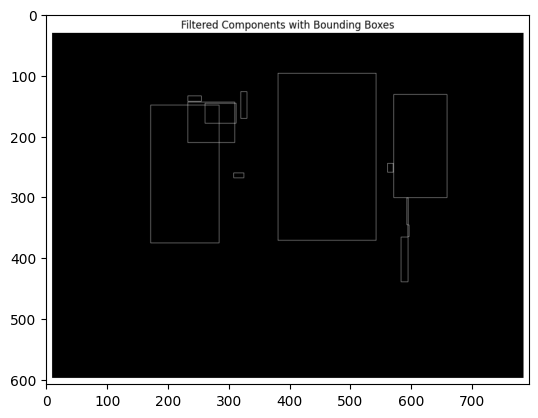

In [4]:
path = "output.png"
image = cv2.imread(path)
plt.imshow(image)

#### Then I modified it a bit and printed out each bbox, here is one of them:

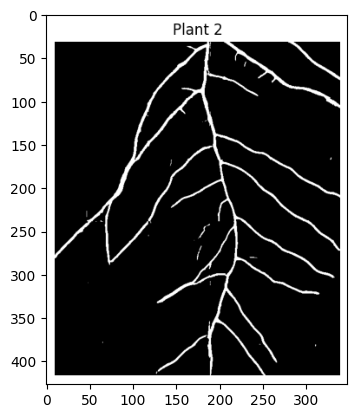

In [2]:
path = "output2.png"
image = cv2.imread(path)
plt.imshow(image)

#### Then finally I was able to get the right bboxes around each plant for the test image:

In [ ]:
def display_image(img, title="Image", cmap='gray'):
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

image_path = ""
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

blurred = cv2.GaussianBlur(image, (5, 5), 0)

thresh = cv2.adaptiveThreshold(blurred, 200, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

kernel = np.ones((3,3), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)

sorted_stats = sorted(stats[1:], key=lambda x: x[cv2.CC_STAT_AREA], reverse=True)

output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

for i in range(min(4, len(sorted_stats))):
    x, y, w, h, area = sorted_stats[i]
    cv2.rectangle(output_image, (x, y), (x+w, y+h), (0, 255, 0), 2)

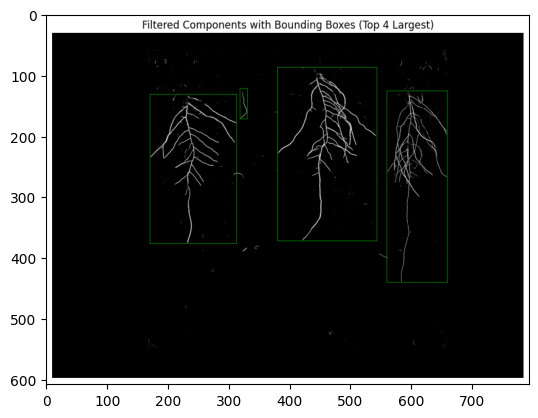

In [7]:
path = "output3.png"
image = cv2.imread(path)
plt.imshow(image)

## Task 7 & 8

#### In my task 8 notebook I included all of the previous things into one or two steps of the process now, here are the first things I did:

In [ ]:
image_dir = ""
output_dir = ""

image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))

for idx, img_path in enumerate(image_paths):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (0, 0), fx=scaling_factor, fy=scaling_factor)
    image, bbox = crop_petri_dish(image)
    image_padded = padder(image, patch_size)
    image_patches = patchify(image_padded, (patch_size, patch_size, 3), step=patch_size)
    #image_patches = patchify(image_padded, (patch_size, patch_size, 3), step=patch_size).reshape(-1, patch_size, patch_size)
    image_patches = np.squeeze(image_patches)
    i = image_patches.shape[0]
    j = image_patches.shape[1] 
    image_patches_reshaped = image_patches.reshape(-1, patch_size, patch_size, 3)
    predicted_mask = model.predict(image_patches_reshaped/255)
    predicted_mask = predicted_mask.reshape(i, j, 128, 128) 
    num_patches = predicted_mask.shape[0]
    target_shape = (num_patches * patch_size, num_patches * patch_size)
    predicted_mask = unpatchify(predicted_mask, target_shape)

    output_path = os.path.join(output_dir, f"predicted_mask_{idx}.png")
    cv2.imwrite(output_path, predicted_mask * 255)

#### This was my first version of the patchify, padding, predictimng, unpatchifying and then saving the predicted masks all together.

In [ ]:
def extract_number(filename):
    parts = re.findall(r'\d+', filename)
    return int(parts[-1]) if parts else 0

def padder(image, target_size):
    height, width, channels = image.shape
    pad_height = (target_size - height % target_size) % target_size
    pad_width = (target_size - width % target_size) % target_size
    padded_image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

def patchify(img, patch_shape, step):
    img_height, img_width, channels = img.shape
    patches = []
    for i in range(0, img_height, step):
        for j in range(0, img_width, step):
            patch = img[i:i + patch_shape[0], j:j + patch_shape[1]]
            if patch.shape[0] == patch_shape[0] and patch.shape[1] == patch_shape[1]:
                patches.append(patch)
    return np.array(patches)

def unpatchify(patches, target_shape):
    patch_height, patch_width = patches.shape[1], patches.shape[2]
    num_patches = patches.shape[0]
    img_height, img_width = target_shape[0], target_shape[1]
    num_patches_height = img_height // patch_height
    num_patches_width = img_width // patch_width
    image = np.zeros(target_shape, dtype=patches.dtype)
    patch_idx = 0
    for i in range(num_patches_height):
        for j in range(num_patches_width):
            if patch_idx < num_patches:
                image[i * patch_height:(i + 1) * patch_height,
                      j * patch_width:(j + 1) * patch_width] = patches[patch_idx]
                patch_idx += 1
    return image

model_path = ''
model = load_model(model_path, custom_objects={"f1": f1})

image_dir = ""
output_dir = ""
os.makedirs(output_dir, exist_ok=True)

image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")), key=extract_number)

for idx, img_path in enumerate(image_paths):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    cropped_image, bbox = crop_petri_dish(image)
    padded_image = padder(cropped_image, 256)
    original_size = padded_image.shape[:2]
    image_patches = patchify(padded_image, (256, 256, 3), 256)
    image_patches_reshaped = image_patches.reshape(-1, 256, 256, 3)
    predicted_masks = model.predict(image_patches_reshaped / 255.0)
    predicted_mask = predicted_masks.reshape(-1, 256, 256)
    combined_mask = unpatchify(predicted_mask, padded_image.shape[:2])
    final_mask = combined_mask[:original_size[0], :original_size[1]]
    output_path = os.path.join(output_dir, f"predicted_mask_{idx}.png")
    cv2.imwrite(output_path, final_mask * 255)

#### This is the second version, I added funcions for patchifying, unpatchifying, padding, then I load the model, predict the masks and save them.

#### Then here is the first instance of skeletonization, applying the methods from task 6 of seperating each plant by their bboxes with a skeletonization function applied to it:

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, img_as_ubyte

def display_image(img, title="Image", cmap=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def skeletonize_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_image = binary_image > 0
    skeleton = morphology.skeletonize(binary_image)
    return img_as_ubyte(skeleton)

image_path = r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\Kaggle\predicted masks\2\predicted_mask_12.png"
color_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)

thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

kernel = np.ones((3, 3), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)

sorted_stats = sorted(stats[1:], key=lambda x: x[cv2.CC_STAT_AREA], reverse=True)

for i in range(min(5, len(sorted_stats))):
    x, y, w, h, area = sorted_stats[i]
    cropped_image = color_image[y:y+h, x:x+w]
    skeletonized_image = skeletonize_image(cropped_image)
    display_image(skeletonized_image, f"Skeletonized Plant {i}", cmap='gray')

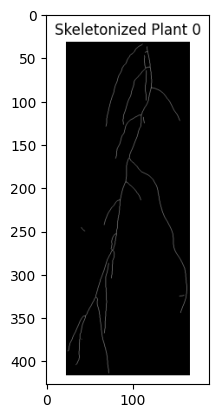

In [8]:
path = "output4.png"
image = cv2.imread(path)
plt.imshow(image)

#### This time I got to task 7 to analyze the root pixels. First I used NetworkX to converting it to a graph and then analyzing the largest connected components. It worked well, but sometimes it would take the wrong starting points and it wouldnt use the actual path, it would just record the pixel length from points to point directly and would miss some pixels that way.

In [ ]:
def display_image(img, title="Image", cmap='gray'):
    plt.figure(figsize=(5, 5))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def skeletonize_image(image):
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    skeleton = skeletonize(binary_image > 0)
    return img_as_ubyte(skeleton)

image_path = ""
color_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

kernel = np.ones((3, 3), np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)
sorted_stats = sorted(stats[1:], key=lambda x: x[cv2.CC_STAT_AREA], reverse=True)

for i in range(min(5, len(sorted_stats))):
    x, y, w, h, area = sorted_stats[i]
    cropped_image = gray_image[y:y+h, x:x+w]
    skeletonized_image = skeletonize_image(cropped_image)

    if np.sum(skeletonized_image) == 0:
        print(f"Component {i} is empty after skeletonization.")
        continue

    skeleton, coordinates = skeleton_to_csgraph(skeletonized_image)
    summary = summarize(Skeleton(skeletonized_image))
    G = nx.from_pandas_edgelist(summary, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
    positions = {node: (c[1], c[0]) for node, c in enumerate(coordinates)}

    largest_cc = max(nx.connected_components(G), key=len)
    subgraph = G.subgraph(largest_cc)
    first_node, last_node = min(largest_cc), max(largest_cc)
    path_length = nx.dijkstra_path_length(subgraph, source=first_node, target=last_node, weight='branch-distance')
    print(f"Component {i} primary path length: {path_length}")

    fig, ax = plt.subplots()
    nx.draw(subgraph, pos=positions, ax=ax, node_size=1, with_labels=False)
    ax.imshow(skeletonized_image, cmap='gray')
    plt.title(f"Skeletonized Plant {i}")
    plt.show()

### The same problem occurred here where the paths didnt take the actual path of the root resulting in missing pixels and it also added  closing operations making the mask thicker.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, img_as_ubyte
from skimage.morphology import skeletonize
from skan import summarize, Skeleton
import networkx as nx

def skeletonize_image(image):
    # Skeletonize the binary image
    skeleton = skeletonize(image > 0)
    # Convert the skeletonized image back to uint8 for displaying
    return img_as_ubyte(skeleton)

def preprocess_image(gray_image):
    # Apply Gaussian Blur and adaptive threshold
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    # Apply morphological operations to clean the image
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    return closing

def remove_small_components(image, min_size=100):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, -1]
    img2 = np.zeros(output.shape)
    for i in range(1, nb_components):
        if sizes[i-1] >= min_size:
            img2[output == i] = 255
    return img2.astype(np.uint8)

# Load the image
image_path = r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\Kaggle\predicted masks\2\predicted_mask_12.png"  # Update this path
color_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

# Preprocess and clean the image
closing = preprocess_image(gray_image)
cleaned = remove_small_components(closing)

# Segment into 5 vertical parts and analyze
segment_width = cleaned.shape[1] // 5
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cleaned, cmap='gray')
for i in range(5):
    segment = cleaned[:, i*segment_width:(i+1)*segment_width]
    if np.sum(segment) == 0:
        print(f"Segment {i} is empty.")
        continue

    skeletonized_image = skeletonize_image(segment)
    skeleton, coordinates = skeleton_to_csgraph(skeletonized_image)
    summary = summarize(Skeleton(skeletonized_image))
    G = nx.from_pandas_edgelist(summary, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
    positions = {node: (coordinates[node][1] + i*segment_width, coordinates[node][0]) for node in G.nodes()}

    largest_cc = max(nx.connected_components(G), key=len)
    subgraph = G.subgraph(largest_cc)
    first_node, last_node = min(largest_cc), max(largest_cc)
    path_length = nx.dijkstra_path_length(subgraph, source=first_node, target=last_node, weight='branch-distance')
    
    print(f"Segment {i}, Path length: {path_length}")
    nx.draw(subgraph, pos=positions, ax=ax, node_size=1, with_labels=False, node_color='blue', edge_color='red')

plt.title("Skeletonized Plants with Paths")
plt.axis('off')
plt.show()

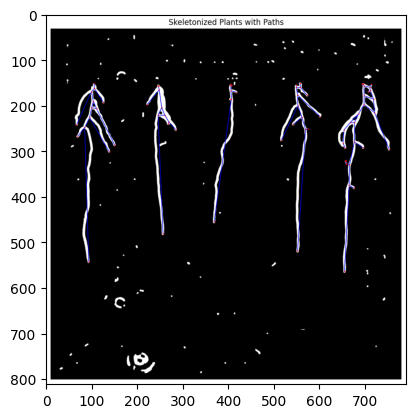

In [4]:
path = "output7.png"
image = cv2.imread(path)
plt.imshow(image)

#### Then I analyzed the skeleton using Dijkstras algorith with networkX, to find the biggest path from the top most node to the bottom most one. This finally made it follow the path correctly, counting most of the pixels correctly leading to a more accurate length prediction.

In [ ]:
def display_image(img, title="Image", cmap='gray'):
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def skeletonize_image(image):
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    skeleton = morphology.skeletonize(binary_image > 0)
    return skeleton

def analyze_skeleton(skeleton):
    labeled_skeleton, _ = measure.label(skeleton, connectivity=2, return_num=True)
    properties = measure.regionprops(labeled_skeleton)
    if properties:
        largest_component = max(properties, key=lambda x: x.area).label
        main_skeleton = labeled_skeleton == largest_component
        graph = nx.Graph()
        for r, c in np.argwhere(main_skeleton):
            for offsets in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                rr, cc = r + offsets[0], c + offsets[1]
                if 0 <= rr < skeleton.shape[0] and 0 <= cc < skeleton.shape[1] and main_skeleton[rr, cc]:
                    graph.add_edge((r, c), (rr, cc))
        if nx.is_empty(graph):
            return [], 0
        path = nx.dijkstra_path(graph, source=list(graph.nodes())[0], target=list(graph.nodes())[-1])
        length = nx.dijkstra_path_length(graph, source=list(graph.nodes())[0], target=list(graph.nodes())[-1])
        return path, length
    return [], 0

def draw_path_on_image(image, path, color=(255, 0, 0)):
    for i in range(len(path)-1):
        cv2.line(image, (path[i][1], path[i][0]), (path[i+1][1], path[i+1][0]), color, 2)

image_path = r""
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
segment_width = gray_image.shape[1] // 5

overlay_image = original_image.copy()

for i in range(5):
    x_start = i * segment_width
    x_end = (i + 1) * segment_width if i < 4 else gray_image.shape[1]
    cropped_image = gray_image[:, x_start:x_end]
    skeletonized_image = skeletonize_image(cropped_image)
    path, length = analyze_skeleton(skeletonized_image)
    
    if path:
        print(f"Longest path length for segment {i+1}: {length} pixels")
        adjusted_path = [(r, c + x_start) for r, c in path]
        draw_path_on_image(overlay_image, adjusted_path)
    else:
        print(f"No valid path found for segment {i+1}")

display_image(overlay_image, "Segmented Analysis of Plants")

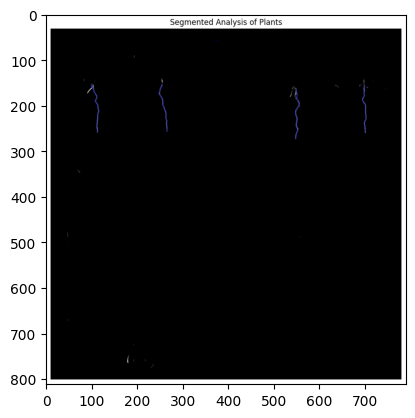

In [9]:
path = "output5.png"
image = cv2.imread(path)
plt.imshow(image)

### For the last one I highlighted the root tips.

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from skimage import morphology, measure
import networkx as nx
import re
import matplotlib.pyplot as plt

def sort_numerically(file_list):
    """Sort file list numerically based on numbers in filenames."""
    return sorted(file_list, key=lambda x: int(re.search(r'\d+', x).group()))

def skeletonize_image(image):
    """Convert image to binary and apply skeletonization."""
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    skeleton = morphology.skeletonize(binary_image > 0)
    return skeleton

def analyze_skeleton(skeleton):
    """Analyze skeleton to find the longest path using Dijkstra's algorithm."""
    labeled_skeleton, _ = measure.label(skeleton, connectivity=2, return_num=True)
    properties = measure.regionprops(labeled_skeleton)

    if properties:
        largest_component = max(properties, key=lambda x: x.area).label
        main_skeleton = labeled_skeleton == largest_component
        graph = nx.Graph()
        for r, c in np.argwhere(main_skeleton):
            for offsets in [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]:
                rr, cc = r + offsets[0], c + offsets[1]
                if 0 <= rr < skeleton.shape[0] and 0 <= cc < skeleton.shape[1] and main_skeleton[rr, cc]:
                    graph.add_edge((r, c), (rr, cc))

        if len(graph.nodes) > 1:  # Ensure there are enough nodes for a path
            path = nx.dijkstra_path(graph, source=list(graph.nodes())[0], target=list(graph.nodes())[-1])
            length = nx.dijkstra_path_length(graph, source=list(graph.nodes())[0], target=list(graph.nodes())[-1])

            # Ignore paths shorter than 30 pixels
            if length < 30:
                return [], 0, None

            root_tip = path[-1]  # The last node in the longest path
            return path, length, root_tip
    return [], 0, None

def draw_path_on_image(image, path, color=(0, 0, 255)):
    """Draw the skeleton path on the image."""
    for i in range(len(path) - 1):
        cv2.line(image, (path[i][1], path[i][0]), (path[i+1][1], path[i+1][0]), color, 2)

def process_folder_to_csv_numerical(image_folder, output_csv):
    """Process a folder of images, save path lengths & root tip positions to CSV, and overlay paths on images."""
    results = []
    image_files = sort_numerically([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

    for image_idx, image_file in enumerate(image_files, start=1):
        image_path = os.path.join(image_folder, image_file)
        original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

        # Ignore the top 10% of the image
        ignore_top = int(gray_image.shape[0] * 0.10)
        filtered_gray_image = gray_image[ignore_top:, :]

        segment_width = filtered_gray_image.shape[1] // 5
        overlay_image = original_image.copy()  # Copy image for overlay

        print(f"\nProcessing {image_file}...\n")

        for segment_idx in range(5):
            x_start = segment_idx * segment_width
            x_end = (segment_idx + 1) * segment_width if segment_idx < 4 else filtered_gray_image.shape[1]

            cropped_segment = filtered_gray_image[:, x_start:x_end]
            skeletonized_segment = skeletonize_image(cropped_segment)
            path, length, root_tip = analyze_skeleton(skeletonized_segment)

            # Generate Plant ID in the correct order
            plant_id = f"test_image_{image_idx}_plant_{segment_idx + 1}"

            if not path or length < 30:
                length = 0
                root_tip = None  # No root detected

            # Adjust path coordinates to match original image height
            adjusted_path = [(r + ignore_top, c + x_start) for r, c in path] if path else []
            root_tip_adjusted = (root_tip[0] + ignore_top, root_tip[1] + x_start) if root_tip else (None, None)

            # Draw the path onto the overlay image
            if adjusted_path:
                draw_path_on_image(overlay_image, adjusted_path)

            results.append({
                "Plant ID": plant_id,
                "Length (px)": length,
                "Root Tip (x, y)": root_tip_adjusted
            })

            print(f"  📏 {plant_id}: Length = {length} pixels, Root Tip = {root_tip_adjusted}")

        # Display the overlay image
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Segmented Analysis: {image_file}")
        plt.show()

    # Save the results to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"\n📂 Results saved to {output_csv}")

# Parameters
image_folder = r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\Kaggle\predicted masks\112"
output_csv = r"C:\Users\emilp\Documents\Buas_Y2\Block_B\data_sets\results_correct_orderrrr.csv"

# Process the folder, save to CSV, and create overlay images
process_folder_to_csv_numerical(image_folder, output_csv)

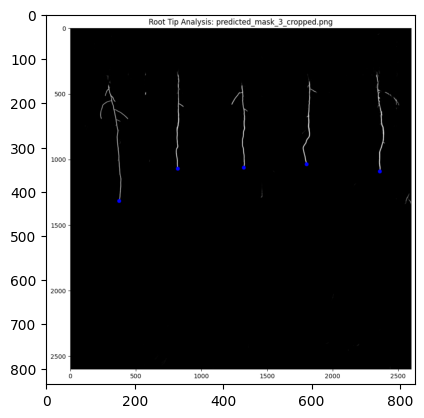

In [8]:
path = "output6.png"
image = cv2.imread(path)
plt.imshow(image)